In [1]:
# QiskitRuntimeService.save_account('e5bbe0fc980e8673d14b3747823ef4417670c4ad8da6f408aa64f197190c6f46edc30132ca1ff09a1831895de0ff34dfcb4f0e3b6fed831ddfcc30acc17b8a81')

In [2]:
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2, EstimatorV2, QiskitRuntimeService

#### Define Sampler Instances

In [3]:
backend_aer = AerSimulator()
backend_ibm = QiskitRuntimeService().get_backend('ibm_osaka')

RequestsApiError: 'HTTPSConnectionPool(host=\'auth.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/version (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f96068845b0>: Failed to resolve \'auth.quantum-computing.ibm.com\' ([Errno -3] Temporary failure in name resolution)"))'

In [ ]:
sampler_aer = SamplerV2(backend=backend_aer)
sampler_ibm = SamplerV2(backend=backend_ibm)

#### Create Circuits

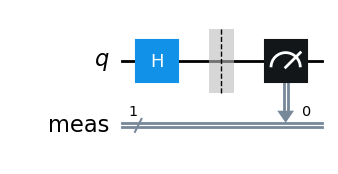

In [ ]:
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.measure_all()
qc1.draw()

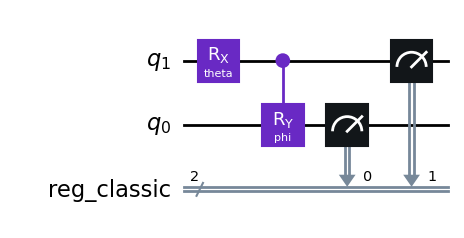

In [ ]:
theta = Parameter('theta')
phi = Parameter('phi')

qr = QuantumRegister(2, name='q')
cr = ClassicalRegister(2, name='reg_classic')

qc2 = QuantumCircuit(qr, cr)
qc2.rx(theta, 1)
qc2.cry(phi, 1, 0)
qc2.measure(qr, cr)
qc2.draw()

In [ ]:
angles = [ [pi/4, pi/2], [pi/3, pi], [pi/2, pi] ]

In [ ]:
qc2.parameters

ParameterView([Parameter(phi), Parameter(theta)])

#### Transpile Circuits

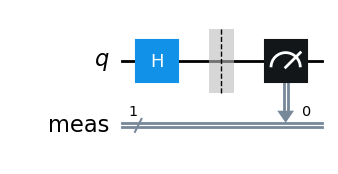

In [ ]:
qc1_aer = transpile(qc1, backend=backend_aer)
qc1_aer.draw()

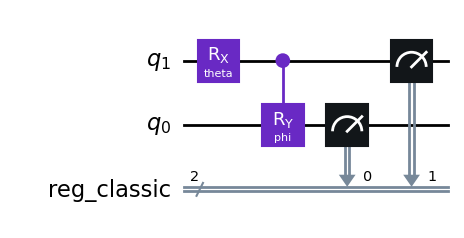

In [ ]:
qc2_aer = transpile(qc2, backend=backend_aer)
qc2_aer.draw()

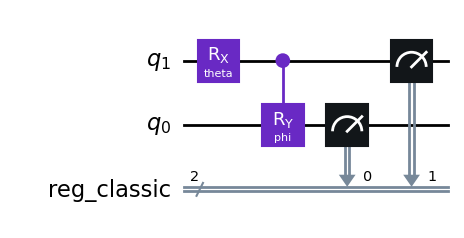

In [30]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend_aer.target
pm = generate_preset_pass_manager(target=target, optimization_level=1)
qc2_aer = pm.run(qc2)
qc2_aer.draw()

#### Execute using Sampler

In [31]:
job_aer = sampler_aer.run([(qc1_aer, None, 100), (qc2_aer, angles, 1000)])
# job_ibm = sampler_ibm.run([(qc1_aer, None, 100), (qc2_aer, angles, 1000)])

In [32]:
# job_ibm = QiskitRuntimeService().job('job-id')

In [33]:
result_aer = job_aer.result()
# result_ibm = job_ibm.result()

In [34]:
counts_qc1_aer = result_aer[0].data.meas.get_counts()
# counts_qc1_ibm = result_ibm[0].data.meas.get_counts()

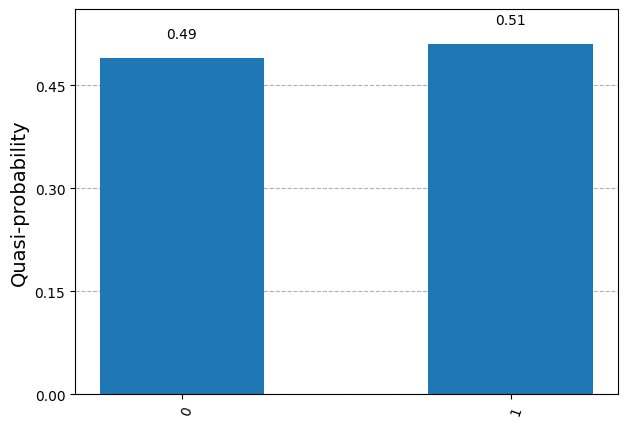

In [35]:
plot_distribution([counts_qc1_aer])

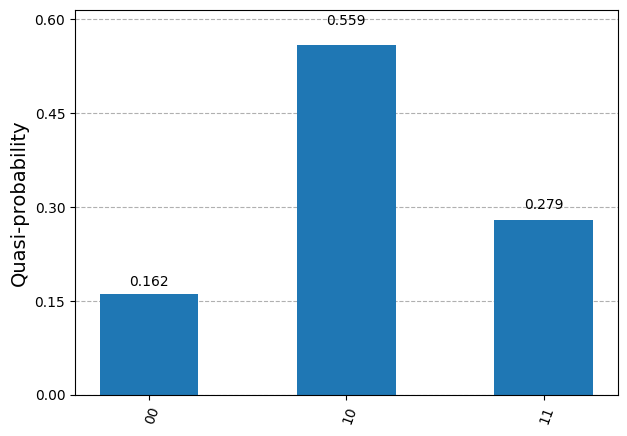

In [36]:
counts_qc2_aer = result_aer[1].data.reg_classic.get_counts()

plot_distribution([counts_qc2_aer])

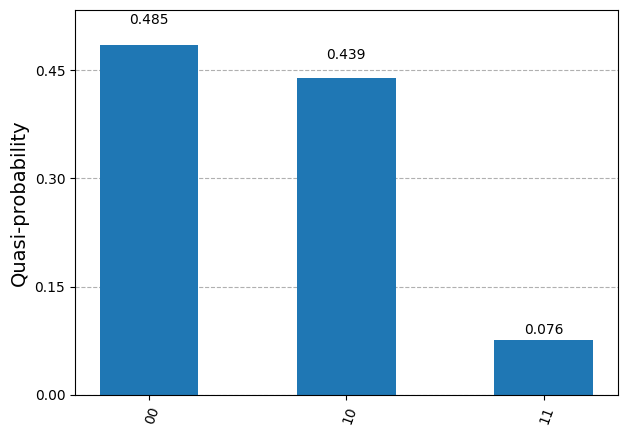

In [37]:
counts_qc2_aer_angle0 = result_aer[1].data.reg_classic.get_counts(0)

plot_distribution([counts_qc2_aer_angle0])

#### Define Estimator Instances

In [38]:
estimator_aer = EstimatorV2(backend=backend_aer)
# estimator_ibm = EstimatorV2(backend=backend_ibm)

In [39]:
obsv_list = [
    [SparsePauliOp(['XX', 'IY'], [0.5, 0.5])],
    [SparsePauliOp(['XX'], [1])],
    [SparsePauliOp(['IY'], [1])]
]

obsv_list = [
    [SparsePauliOp(['II'], [-0.5597])],
    [SparsePauliOp(['IZ'], [ 0.1615])],
    [SparsePauliOp(['ZI'], [-0.0166])],
    [SparsePauliOp(['ZZ'], [ 0.4148])],
    [SparsePauliOp(['YY'], [ 0.1266])],
    [SparsePauliOp(['XX'], [ 0.1266])]
]

In [40]:
# Map observables to backend layout

layout = qc2_aer.layout 
# layout = qc2_ibm.layout 

obsv_ibm = []
for obsv in obsv_list:
    obsv_temp = obsv[0].apply_layout(layout)
    print(obsv_temp)
    obsv_ibm.append([obsv_temp])

SparsePauliOp(['II'],
              coeffs=[-0.5597+0.j])
SparsePauliOp(['IZ'],
              coeffs=[0.1615+0.j])
SparsePauliOp(['ZI'],
              coeffs=[-0.0166+0.j])
SparsePauliOp(['ZZ'],
              coeffs=[0.4148+0.j])
SparsePauliOp(['YY'],
              coeffs=[0.1266+0.j])
SparsePauliOp(['XX'],
              coeffs=[0.1266+0.j])


In [41]:
job2_aer = estimator_aer.run([(qc2_aer, obsv_list, angles, 0.01)])
# job2_ibm = estimator_ibm.run([(qc2_ibm, obsv_ibm, angles, 0.01)])

In [42]:
# job2_ibm = QiskitRuntimeService().job('job-id')

In [43]:
exp_vals_aer = job2_aer.result()[0].data.evs
print(exp_vals_aer)

[[-5.5970000e-01 -5.5970000e-01 -5.5970000e-01]
 [ 1.3808250e-01  8.0200900e-02  1.7765000e-03]
 [-4.6480000e-05  1.6600000e-02  1.6600000e-02]
 [ 6.1307440e-02 -2.0598968e-01 -4.5628000e-03]
 [-4.0512000e-04  0.0000000e+00 -6.5832000e-04]
 [-2.5320000e-05  4.3044000e-04  7.3428000e-04]]


three lists each with three separate results, each of the lists corresponds to the results to each of the observables, and the values within each list correspond to the expectation value calculated for each of the different circuits that had different parameter values

#### Sessions with FakeBackend

In [44]:
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend_manila = FakeManilaV2()
sampler_manila = SamplerV2(backend=backend_manila)

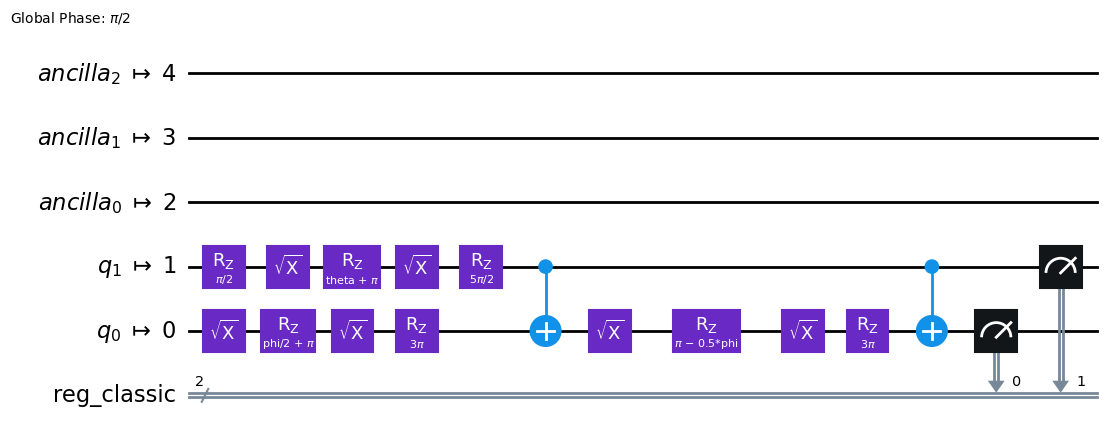

In [45]:
qc2_manila = transpile(qc2, backend=backend_manila)
qc2_manila.draw()

In [46]:
obsv_manila = [ [obsv[0].apply_layout(qc2_manila.layout)] for obsv in obsv_list ]
print(obsv_manila)

[[SparsePauliOp(['IIIII'],
              coeffs=[-0.5597+0.j])], [SparsePauliOp(['IIIIZ'],
              coeffs=[0.1615+0.j])], [SparsePauliOp(['IIIZI'],
              coeffs=[-0.0166+0.j])], [SparsePauliOp(['IIIZZ'],
              coeffs=[0.4148+0.j])], [SparsePauliOp(['IIIYY'],
              coeffs=[0.1266+0.j])], [SparsePauliOp(['IIIXX'],
              coeffs=[0.1266+0.j])]]


In [47]:
with Session(backend=backend_manila) as session:
    print(session)
    # Submit a request to the Sampler primitive within the session
    sampler = SamplerV2(session=session)
    job = sampler.run([(qc2_manila, angles, 1000)])
    pub_result = job.result()[0]
    print(f"1st Circuit Counts: \n {pub_result.data.reg_classic.get_counts(0)} \n")

    # Submit a request to the Estimator primitive within the session
    estimator = EstimatorV2(session=session)
    job = estimator.run([(qc2_manila, obsv_manila, angles, 0.01)])
    pub_result = job.result()[0]
    evs = pub_result.data.evs
    print(f"Expectation values: \n {evs}")

/home/azhar04/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


1st Circuit Counts: 
 {'00': 486, '11': 78, '10': 406, '01': 30} 

Expectation values: 
 [[-5.5970000e-01 -5.5970000e-01 -5.5970000e-01]
 [ 1.4383190e-01  1.4376730e-01  1.4370270e-01]
 [-1.6188320e-02 -1.6204920e-02 -1.6198280e-02]
 [ 3.5979752e-01  3.6071008e-01  3.5971456e-01]
 [-1.3672800e-03 -6.5832000e-04  1.8230400e-03]
 [-1.3419600e-03 -1.6711200e-03  4.8108000e-04]]


In [48]:
evs[0]

array([-0.5597, -0.5597, -0.5597])